In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats

from tqdm.auto import tqdm

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

from google.cloud import bigquery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'viamo-datakind-19b12e3872f5.json'
bq_client = bigquery.Client()

import qgrid

In [2]:
def show_table(df):
    return qgrid.show_grid(df, show_toolbar=True)

In [3]:
sizeQuery = """
SELECT COUNT(*)
FROM
  `viamo-datakind.datadive.321_sessions_1122`
WHERE 
    organization_country = 'Uganda'
"""

pd.read_gbq(sizeQuery).values
# 157 million records just for uganda!

array([[157682886]], dtype=object)

In [4]:
# %%time

# query = """
# SELECT 
#     * 
# FROM 
#     `viamo-datakind.datadive.321_sessions_1122` 
# WHERE 
#     organization_country = 'Uganda'
# ORDER BY rand()
# LIMIT 1000000
# """

# df = pd.read_gbq(query, dialect ='standard', project_id="viamo-datakind", configuration = {'query': {'allowLargeResult': True}})
# df.to_parquet(f'viamo_uganda_1milrows_allcols.gz', index=False, compression='gzip')

In [5]:
# %%time

# query = """
# SELECT 
#     * 
#     EXCEPT(
#         block_global_created_at,
#         rural_or_urban, 
#         phone_type, 
#         education_level, 
#         income_source,
#         airtime_expense, 
#         highest_expense_area, 
#         data_usage_consent,
#         organization_id,
#         block_interaction_id, 
#         location_level_2, 
#         region,
#         region_name
#         ) 
# FROM 
#     `viamo-datakind.datadive.321_sessions_1122` 
# WHERE 
#     organization_country = 'Uganda'
# ORDER BY rand()
# LIMIT 1000000
# """

# df = pd.read_gbq(query, dialect ='standard', project_id="viamo-datakind", configuration = {'query': {'allowLargeResult': True}})
# df.to_parquet(f'viamo_uganda_1milrows.gz', index=False, compression='gzip')

# Queried a randomly sampled data of 1 mil rows from Uganda

In [6]:
df=pd.read_parquet("viamo_uganda_1milrows_allcols.gz")

In [7]:
df.duplicated().sum()

0

In [8]:
ids = [col for col in df.columns if col.endswith('_id')]
print(ids)

df[ids]=df[ids].astype('category')

['block_interaction_id', 'call_id', 'subscriber_id', 'tree_version_set_id', 'organization_id']


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 44 columns):
 #   Column                          Non-Null Count    Dtype              
---  ------                          --------------    -----              
 0   call_date                       1000000 non-null  dbdate             
 1   dl_global_created_at            1000000 non-null  datetime64[ns, UTC]
 2   block_interaction_id            1000000 non-null  category           
 3   call_id                         1000000 non-null  category           
 4   subscriber_id                   1000000 non-null  category           
 5   block_global_created_at         1000000 non-null  datetime64[ns, UTC]
 6   block_entry_at                  1000000 non-null  datetime64[ns, UTC]
 7   js_key                          1000000 non-null  object             
 8   tree_version_set_id             1000000 non-null  category           
 9   call_started                    1000000 non-null  datetime

### Assessing field sparsity - what percentage of a given variable response is nulls?

In [10]:
(df.isnull().sum()/len(df)*100).sort_values()

call_date                           0.0000
organization_id                     0.0000
region_name                         0.0000
region                              0.0000
block_theme                         0.0000
block_tags                          0.0000
call_ended                          0.0000
call_started                        0.0000
tree_version_set_id                 0.0000
js_key                              0.0000
block_entry_at                      0.0000
block_global_created_at             0.0000
subscriber_id                       0.0000
call_id                             0.0000
block_interaction_id                0.0000
dl_global_created_at                0.0000
organization_country                0.0000
block_topic                         0.0000
duration_listened_minutes           5.9940
duration_listened_seconds           5.9940
block_audio_percent_listened        5.9941
subscriber_pereferred_language      6.7190
block_title                        17.3364
listen_menu

Above information shows the percentage of null vales for each variables.

For example, call date have 0% null values - i.e no null values at all.

Conversely, location_level_2 has around 99.99% null values. There are hardly any useful info in this column.

Variables related to information about both caller and listener have missing values.

In [11]:
df=df.drop([
    'education_level',
    'income_source',
    'airtime_expense',
    'highest_expense_area',
    'data_usage_consent',
    'phone_type',
    'rural_or_urban',
    #The above cols only contains null value
    'block_global_created_at', 
    'organization_id', #Only requires 1 category
    'block_interaction_id', 
    'location_level_2', 
    'region',      #only contains EAF since the subset of the data ussed is uganda
    'region_name'   #only contains East Africa since the subset of the data ussed is uganda
], axis=1)

In [12]:
# converting all these cols to categorical
df[[
    'km_block_reached', 'km_block_listened', 'listener', 'new_listener_ever', 'new_listener_year', 'new_caller_ever', 'new_caller_year', 
    'registered_demographic_info'
]]=\
df[[
    'km_block_reached', 'km_block_listened', 'listener', 'new_listener_ever', 'new_listener_year', 'new_caller_ever', 'new_caller_year',
    'registered_demographic_info'
]].astype('category')

In [13]:
def diagnostic_plots(df, variable):

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=10)
    
    # boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(df[variable])

    # Q-Q plot
    plt.subplot(1, 3, 3)
    stats.probplot(df[variable], dist="norm", plot=plt)
    
    plt.suptitle(variable, fontsize = 20)

    plt.show()

`duration_listened_seconds` & `block_audio_percent_listened` distributions

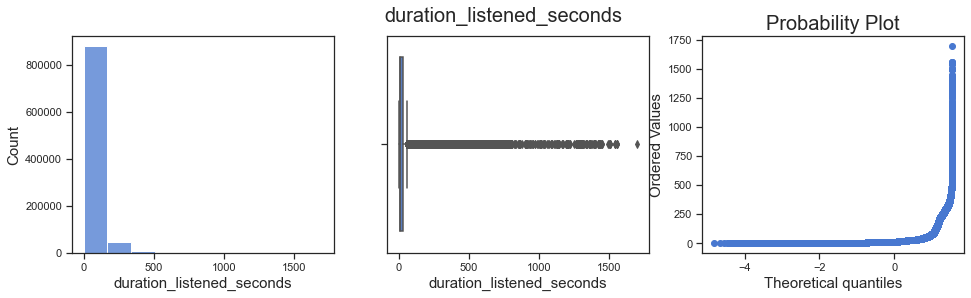

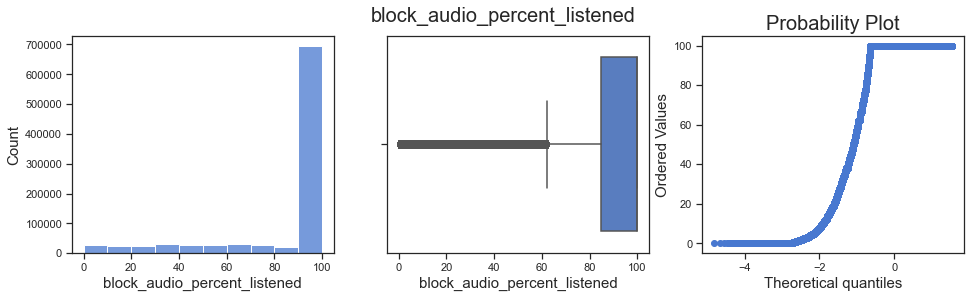

In [14]:
for col in ['duration_listened_seconds', 'block_audio_percent_listened']:
    diagnostic_plots(df, col)

Both `duration_listened_seconds` & `block_audio_percent_listened` are skewed variables.

### Categorical Variables

`listen_menu_or_digest`

In [15]:
def plot_cat(df, col, showfliers, whis):
    
    fig, ax = plt.subplots(3, 1, figsize=(8, 20))

    # countplot
    sns.countplot(y=df[col], orient='h', ax=ax[0]);
    ax[0].set_title('Countplot')
    ax[0].set_xlabel('')
    
    # boxplot 1
    sns.boxplot(
        x='duration_listened_seconds',
        y=col,
        data=df,
        orient='h',
        showfliers=showfliers,
        whis=whis,
        ax=ax[1]
    );
    ax[1].set_ylabel('')
    ax[1].set_title('duration_listened_seconds')

    # boxplot 2
    sns.boxplot(
        x='block_audio_percent_listened',
        y=col,
        data=df,
        orient='h',
        showfliers=showfliers,
        whis=whis,
        ax=ax[2]
    );
    ax[2].set_ylabel('')
    ax[2].set_title('block_audio_percent_listened')

    plt.show()

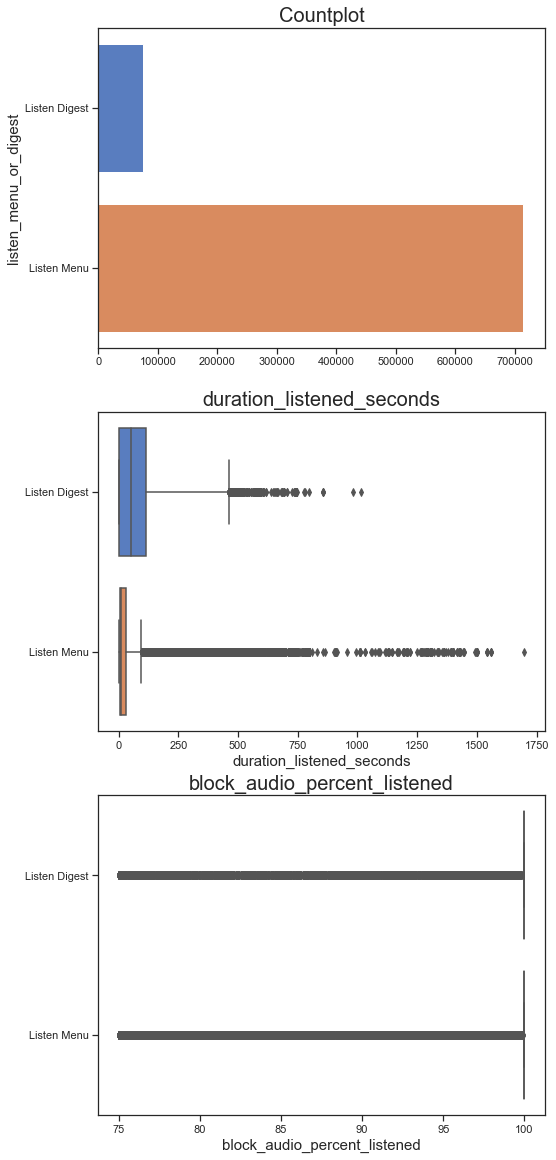

In [16]:
plot_cat(df, 'listen_menu_or_digest', True, 3)

Listeners spends more time listening to Listen Digest compared to Listen Menu. Perhaps once someone makes a call' first they are directed to Listen Menu. Once the listener chooses the option/topic they want to listen to, then the call is directed to Listen digest.

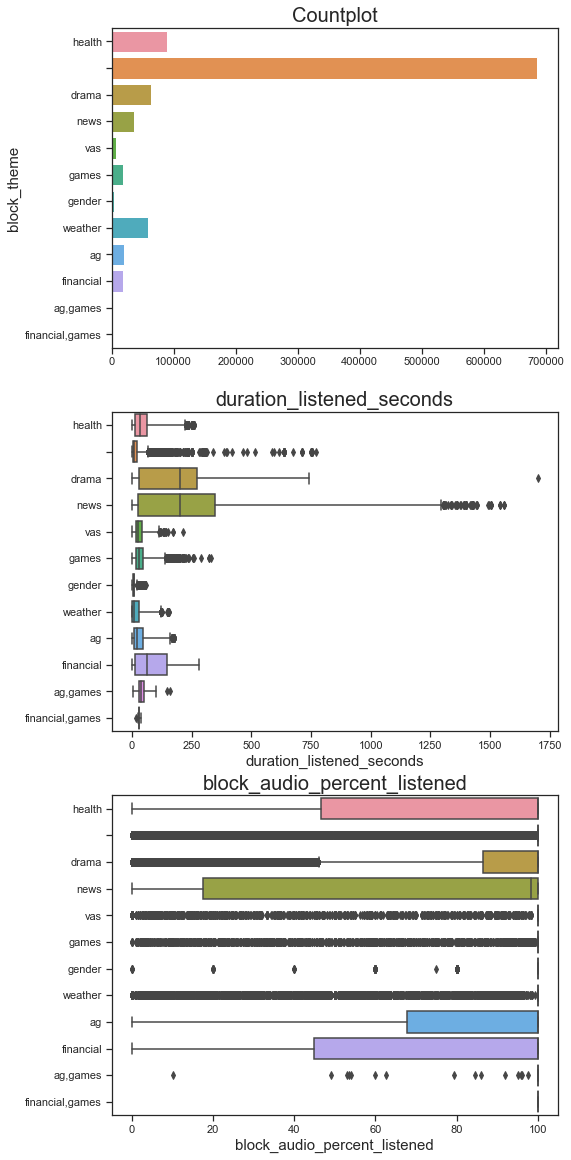

In [17]:
plot_cat(df, 'block_theme', True, 3)

Once of the categories is just a null value ''. Ignoring this category, people spends more time listening to the news and drama.

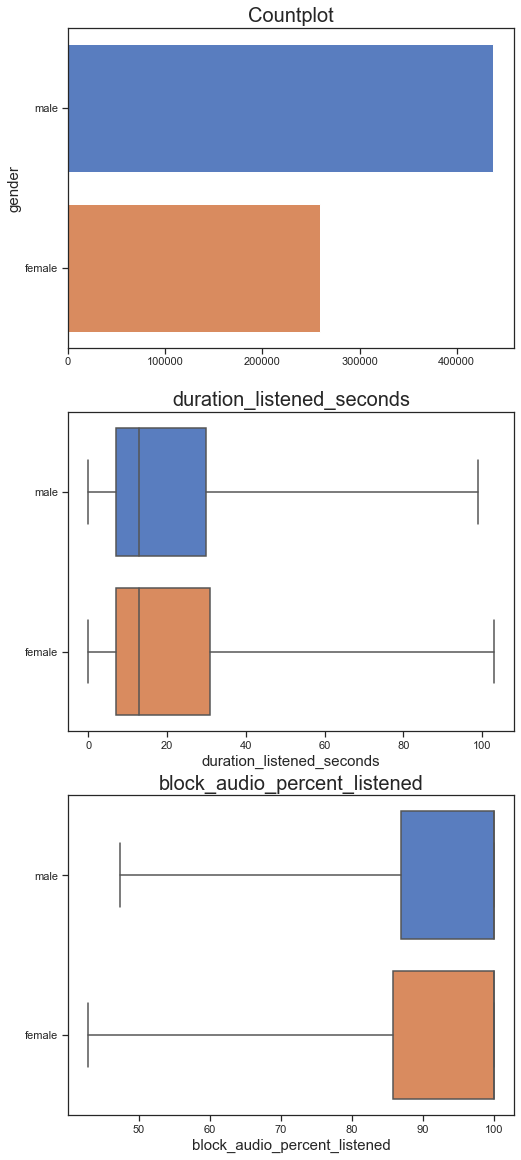

In [18]:
plot_cat(df, 'gender', False, 3)

Although there are more male callers compared to female callers, people from both genders spends almost equal amount of time.

In [19]:
df['block_theme'].unique()

array(['health', '', 'drama', 'news', 'vas', 'games', 'gender', 'weather',
       'ag', 'financial', 'ag,games', 'financial,games'], dtype=object)

In [20]:
df['block_topic'].unique()

array(['coronavirus', '', 'srh', 'cassava', 'hiv,srh', 'maize', 'beans',
       'rice', 'hiv', 'livestock'], dtype=object)

In [21]:
#Replacing '' to null
df['block_theme']=df['block_theme'].replace('', np.nan)
df['block_topic']=df['block_topic'].replace('', np.nan)

In [22]:
#Checking which Topic comes under theme.
df[['block_theme', 'block_topic']].drop_duplicates().sort_values('block_theme')

,block_theme,block_topic
76,ag,cassava
557,ag,rice
251,ag,NaN
181,ag,beans
132,ag,maize
1525,"ag,games",NaN
2,drama,NaN
104,financial,NaN
7619,"financial,games",NaN
41,games,NaN


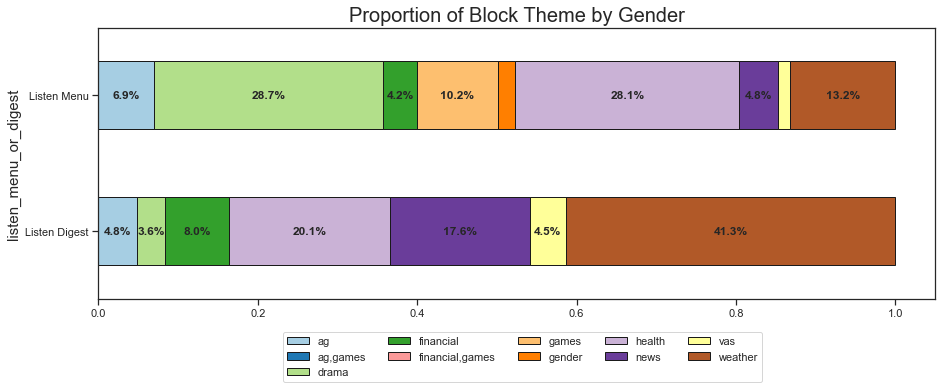

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))

pd.crosstab(index=df['listen_menu_or_digest'], columns=df['block_theme'], normalize='index').plot(kind='barh', stacked=True, ax=ax, cmap='Paired', edgecolor='k')
ax.legend(ncol=5, bbox_to_anchor=(0.8, -0.1));

for c in ax.containers:
    # Filter the labels
    labels = [f'{np.round(v*100, 1)}%' if v > 0.022 else "" for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="center", fontweight = "bold")
    
ax.set_title('Proportion of Block Theme by Gender');

Weather makes up the major proportion the content people listen to in Listen Digest. For Listen menu, people spends more time listening to Drama, followed by health.

In [24]:
#Uploaded a spreadsheet with the block title and corresponsong block theme. There are many missing block theme for many block titles, which can be further improved.
df[['block_title', 'block_theme']].drop_duplicates().sort_values('block_theme')

,block_title,block_theme
41329,2.5.2.3 Upland Rice Soil Health Message,ag
957,2.3.5 Maize Pest and Disease Menu,ag
33709,2.7.3 Nursery Bed Preparation and Seedling care,ag
59153,Beans Pest,ag
22156,2.1.6.2 Beans Post Harvesting Message,ag
...,...,...
866757,Replay Episode 47,NaN
874064,1. How often do you have a drink containing al...,NaN
892860,Clinic 2,NaN
916046,Question 9. How often have you had thoughts th...,NaN


In [25]:
df.loc[df['block_theme'].isnull() & df['block_title'].str.contains(r'episode', case=False), 'block_theme'] = 'drama'

In [26]:
df['block_theme'].value_counts(normalize=True)*100

health             27.706922
drama              22.411779
weather            18.066237
news               11.207899
ag                  5.973651
financial           5.807038
games               5.555727
vas                 2.029650
gender              1.206477
ag,games            0.029675
financial,games     0.004946
Name: block_theme, dtype: float64

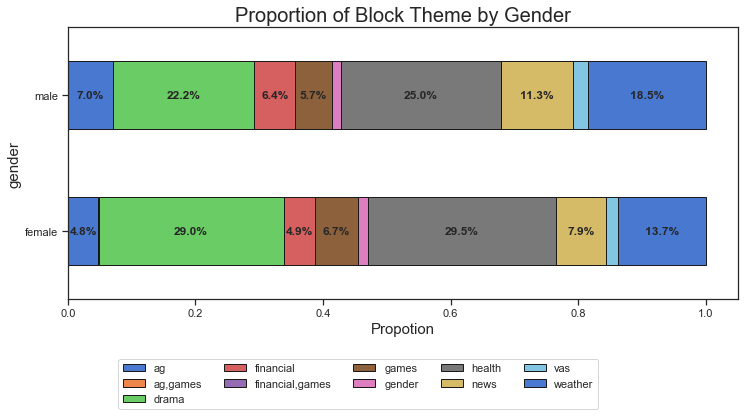

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))

pd.crosstab(index=df['gender'], columns=df['block_theme'], normalize='index').plot(kind='barh', stacked=True, ax=ax, edgecolor='k')
ax.legend(ncol=5, bbox_to_anchor=(0.8, -0.2));

for c in ax.containers:
    # Filter the labels
    labels = [f'{np.round(v*100, 1)}%' if v > 0.025 else "" for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="center", fontweight = "bold")
    
ax.set_title('Proportion of Block Theme by Gender');
ax.set_xlabel('Propotion');

**Null Hypothesis (H0):** There is no association between Gender and Block Theme.

**Alternative hypothesis (H1)**: There is an association between Gender and Block Theme.

In [28]:
data = pd.crosstab(index=df['gender'], columns=df['block_theme']).values

stat, p, dof, expected = stats.chi2_contingency(data)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.0
Dependent (reject H0)


We can see Block theme preferred varies by gender. It seems Female listeners prefers conent such as drama and health more than male listeners. Male listeners prefers weather, news and agriculture content.

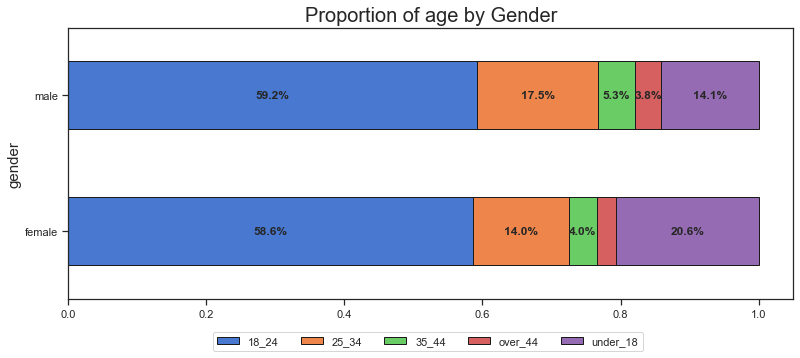

In [29]:
fig, ax = plt.subplots(figsize=(13, 5))

pd.crosstab(index=df['gender'], columns=df['age'], normalize='index').plot(kind='barh', stacked=True, ax=ax, edgecolor='k')
ax.legend(ncol=5, bbox_to_anchor=(0.8, -0.1));

for c in ax.containers:
            # Filter the labels
    labels = [f'{np.round(v*100, 1)}%' if v > 0.03 else "" for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="center", fontweight = "bold")
    
ax.set_title('Proportion of age by Gender');

### Analyzing Listener behavior (Those who have listened at least 75% of the content)

In [30]:
df['listener'].value_counts()

913890058036576256     161
682130153668608000      15
1309821347647982752     13
1305871292108899020     12
1359257822458023192      9
                      ... 
1216293590364848668      1
1216290854458101640      1
731232379863040000       1
1216288761508791056      1
1441538647211378692      1
Name: listener, Length: 141164, dtype: int64

In [31]:
#Categorizing type of lsiteners based on listener_type variable.

#Unknown_listeners are those lsteners with null values.
df.loc[df['listener'].isnull(), 'listener_type'] = 'unknown_listener'

In [32]:
single_listener = df['listener'].value_counts()[df['listener'].value_counts()==1].index #Who listened only 1 time
repeat_listener = df['listener'].value_counts()[df['listener'].value_counts().between(2, 5, inclusive='both')].index #Who listened between 2 and 5 times
committed_listener = df['listener'].value_counts()[df['listener'].value_counts().between(6, 15, inclusive='both')].index #Who listened between 6 and 15 times
super_listener = df['listener'].value_counts()[df['listener'].value_counts()>15].index #Who listened more than 15 times

df.loc[df['listener'].isin(single_listener), 'listener_type'] = 'single_listener'
df.loc[df['listener'].isin(repeat_listener), 'listener_type'] = 'repeat_listener'
df.loc[df['listener'].isin(committed_listener), 'listener_type'] = 'committed_listener'
df.loc[df['listener'].isin(super_listener), 'listener_type'] = 'super_listener'

In [33]:
df['listener_type'].value_counts()

unknown_listener      831592
single_listener       120445
repeat_listener        46986
committed_listener       816
super_listener           161
Name: listener_type, dtype: int64

The above table shows the number of times listeners of the following categories listened to a block title.

In [34]:
df.query('listener_type!="unknown_listener"').groupby(['listener_type']).agg({'listener' : 'nunique'}).sort_values('listener')

,listener
listener_type,
super_listener,1
committed_listener,124
repeat_listener,20594
single_listener,120445


### Keep in mind the above results are from a randomly sampled data of 1 mil rows from Uganda

The above table shows the number of unique listeners for each category. Interestingly, the **super listener** is made up of only 1 person. Commited listeners, who listened to between 6 an 15 times are made up of only 124 listeners.

In [35]:
df.groupby('listener_type')[['duration_listened_seconds', 'block_audio_percent_listened']].median()

,duration_listened_seconds,block_audio_percent_listened
listener_type,,
committed_listener,243.0,100.0
repeat_listener,125.0,100.0
single_listener,72.0,100.0
super_listener,NaN,NaN
unknown_listener,10.0,100.0


In [36]:
df.query("listener_type=='super_listener'")[['duration_listened_seconds', 'block_audio_percent_listened']]

,duration_listened_seconds,block_audio_percent_listened
11804,NaN,NaN
13457,NaN,NaN
23012,NaN,NaN
25908,NaN,NaN
40191,NaN,NaN
...,...,...
989463,NaN,NaN
991778,NaN,NaN
994343,NaN,NaN
998512,NaN,NaN


There are no observations for `duration_listened_seconds` and `block_audio_percent_listened` for super_listener category!

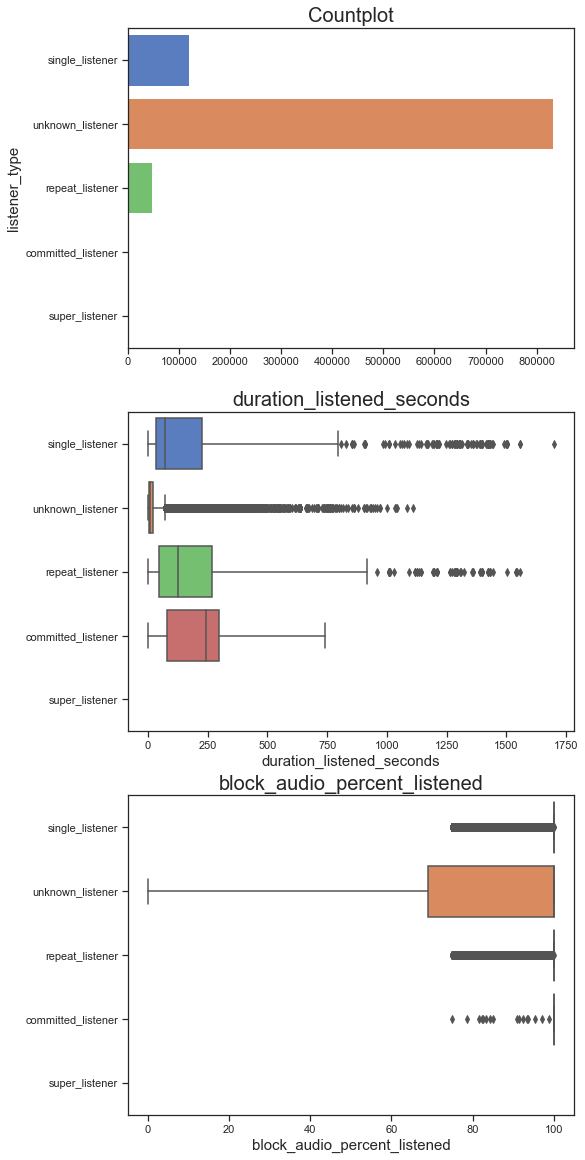

In [37]:
plot_cat(df, 'listener_type', True, 3)

Ignoring both unknown and super listeners, Committed listeners, that has called at least 6 times spends more time on the platform, followed by repeat listeners and then single listeners.

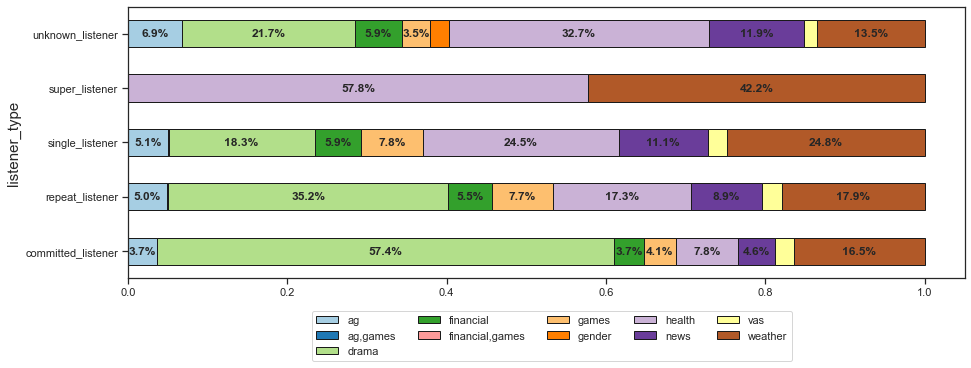

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))

pd.crosstab(index=df['listener_type'], columns=df['block_theme'], normalize='index').plot(kind='barh', stacked=True, ax=ax, cmap='Paired', edgecolor='k')
ax.legend(ncol=5, bbox_to_anchor=(0.8, -0.1));

for c in ax.containers:
    # Filter the labels
    labels = [f'{np.round(v*100, 1)}%' if v > 0.03 else "" for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="center", fontweight = "bold")

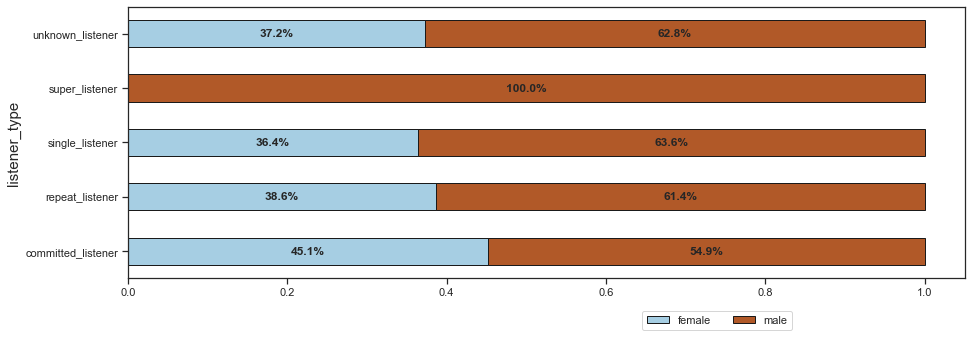

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))

pd.crosstab(index=df['listener_type'], columns=df['gender'], normalize='index').plot(kind='barh', stacked=True, ax=ax, cmap='Paired', edgecolor='k')
ax.legend(ncol=5, bbox_to_anchor=(0.8, -0.1));

for c in ax.containers:
    # Filter the labels
    labels = [f'{np.round(v*100, 1)}%' if v > 0.03 else "" for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="center", fontweight = "bold")

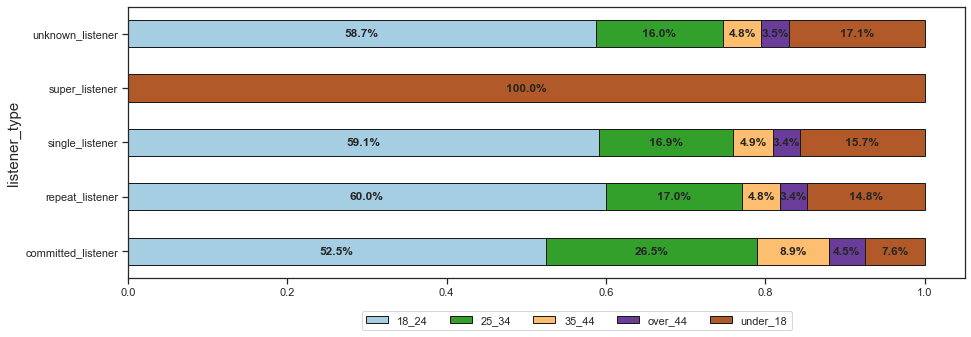

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))

pd.crosstab(index=df['listener_type'], columns=df['age'], normalize='index').plot(kind='barh', stacked=True, ax=ax, cmap='Paired', edgecolor='k')
ax.legend(ncol=5, bbox_to_anchor=(0.8, -0.1));

for c in ax.containers:
    # Filter the labels
    labels = [f'{np.round(v*100, 1)}%' if v > 0.03 else "" for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="center", fontweight = "bold")

From the above 3 plots:

* The **1** Super_listener (calls more than 15 times) is a young male caller aged below 18. He listens to only content related to health and weather.
* Committed listeners (calls between 6 and 15) are more interested in drama theme. This category has more people from 25_34 and 35_44 age groups.
* Repeat listeners has a higher proportion of young people from 18_24, followed by those from 25_34 aged group. Mostly interested in Drama followed by weather and health.
* Single listeners has the same age group proportions as committed listeners. Prefers health and weather topics too followed by drama.

`call_date`

In [41]:
df['call_date']=pd.to_datetime(df['call_date'])

In [42]:
#Extracting year, month, day and dayofweek features

df['year'] = df['call_date'].dt.year
df['month'] = df['call_date'].dt.month
df['day'] = df['call_date'].dt.day
df['dayofweek'] = df['call_date'].dt.dayofweek

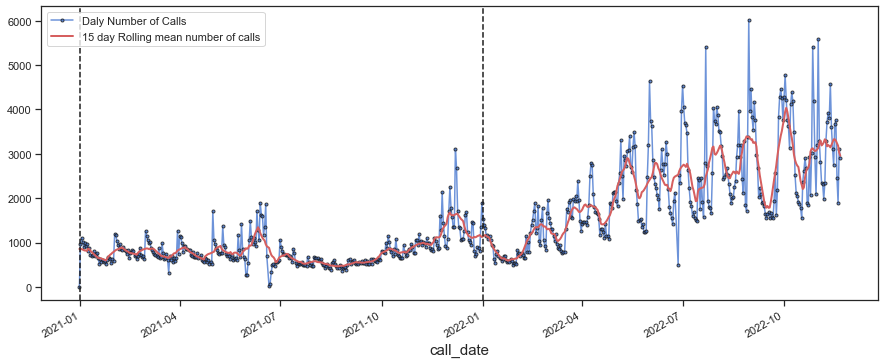

In [43]:
ax=df.groupby('call_date').size().plot(figsize=(15, 6), marker='.', mec='k', alpha=0.8);

df.groupby('call_date').size().rolling(15, center=True, min_periods=7).mean().plot(ax=ax, lw=2, c='r');

ax.legend(labels=['Daly Number of Calls', '15 day Rolling mean number of calls'])

for yr in ['2021-01-01', '2022-01-01']:
    ax.axvline(yr, ls='--', color='k');

The above plots shows a time series of daily number of calls. There seems to be a higher fluctuation of calls on 2022 compared to 2021.

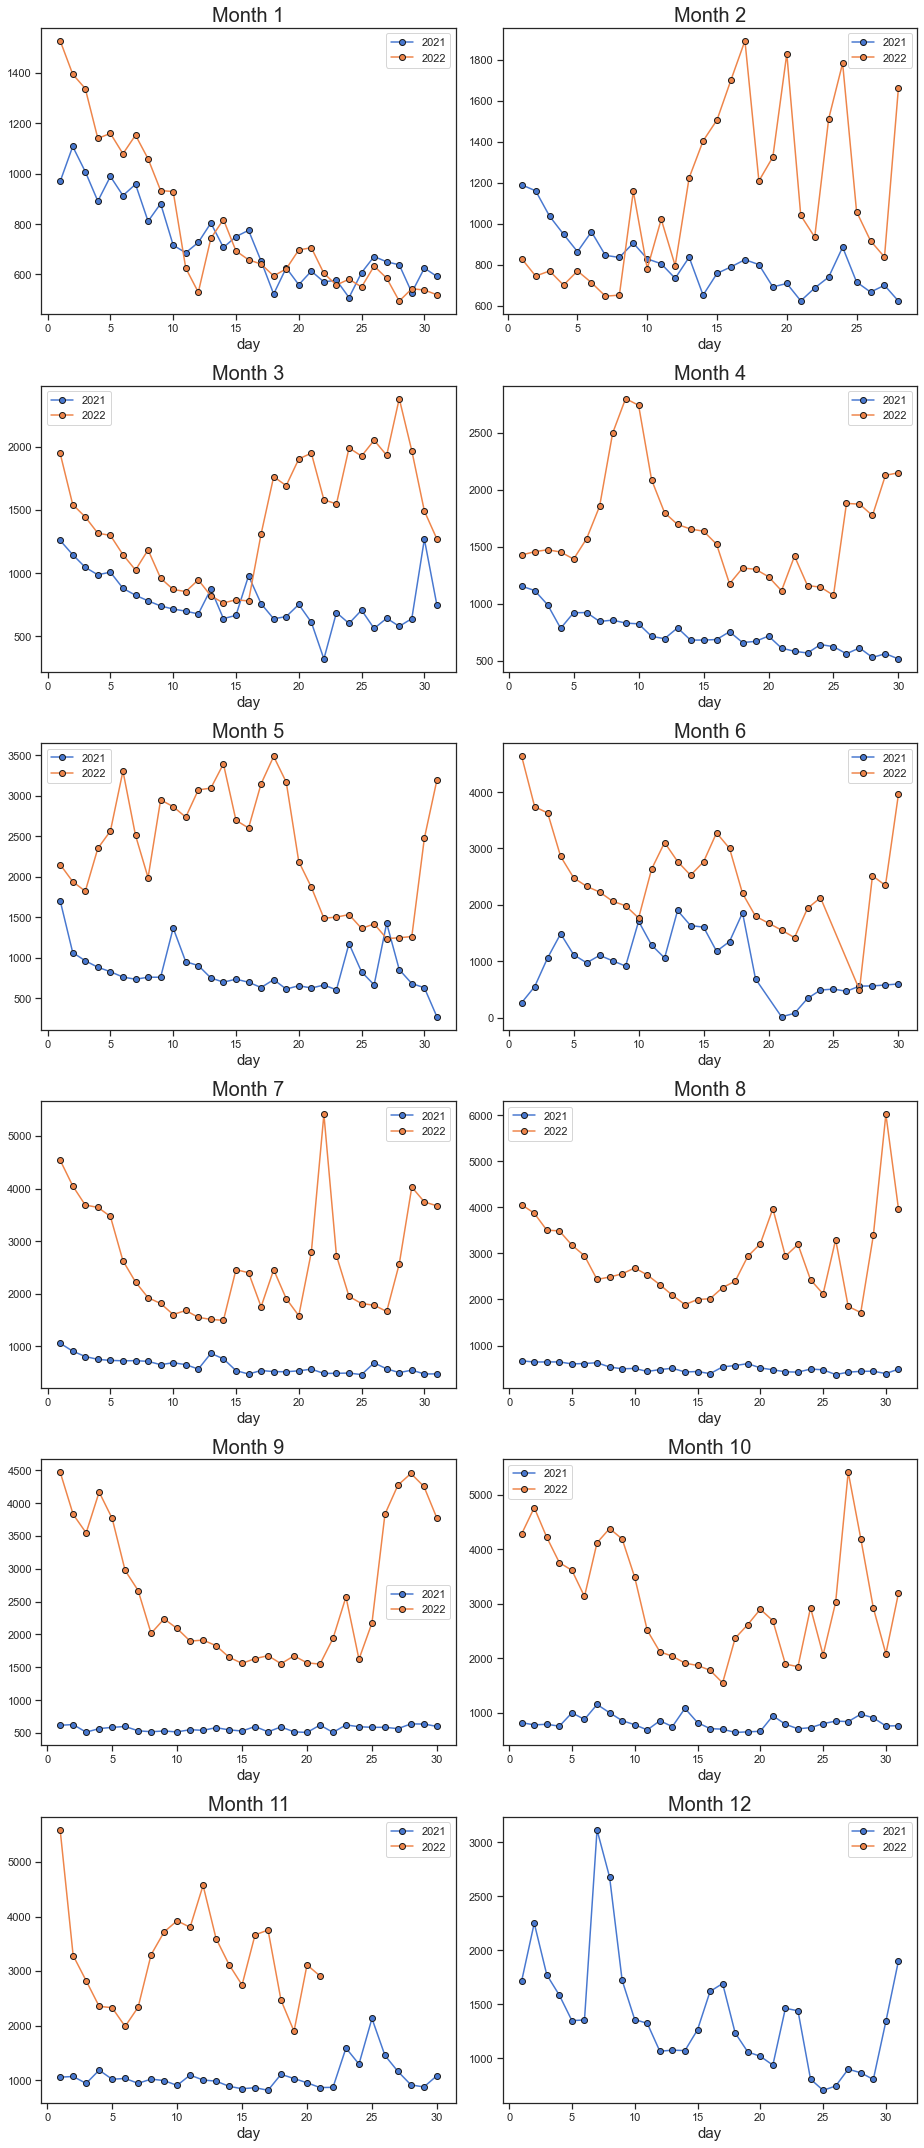

In [44]:
calls_yr_week = df.groupby(['year', 'month', 'day'], as_index=False).size()

fig, axes = plt.subplots(6, 2, figsize=(13, 30), tight_layout=True)

for i, ax in zip(np.arange(1, 13, 1), axes.flatten()):
    
    calls_yr_week.query(f'year==2021 and month=={i}').plot(x='day', y='size', marker='o', mec='k', label='2021', ax=ax)
    calls_yr_week.query(f'year==2022 and month=={i}').plot(x='day', y='size', marker='o', mec='k', label='2022', ax=ax)
    
    ax.set_title(f'Month {i}');

The above plots shows the timeline f daily calls by month. There seems to be no clear monthly or weekly seasonality of calls. 2022 sees more number of calls for every month compared to 2021.